In [25]:
%matplotlib inline

from sklearn import tree
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import re, collections
from datetime import datetime
import glob 
import missingno as msno


import seaborn as sns
plt.style.use('seaborn-colorblind')


pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

import nltk
import tensorflow as tf
import transformers
from transformers import BertTokenizer, TFBertModel
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM

In [6]:
test = pd.read_csv("asap-aes/test_set.tsv",sep='\t', encoding='ISO-8859-1')
dev = pd.read_csv("asap-aes/valid_set.tsv",sep='\t', encoding='ISO-8859-1')
train = pd.read_csv("asap-aes/training_set_rel3.tsv",sep='\t', encoding='ISO-8859-1')

In [11]:
df = train[['essay_id','essay_set','rater1_domain1','rater2_domain1','domain1_score']].copy()
df

,essay_id,essay_set,rater1_domain1,rater2_domain1,domain1_score
0,1,1,4,4,8
1,2,1,5,4,9
2,3,1,4,3,7
3,4,1,5,5,10
4,5,1,4,4,8
...,...,...,...,...,...
12971,21626,8,17,18,35
12972,21628,8,15,17,32
12973,21629,8,20,26,40
12974,21630,8,20,20,40


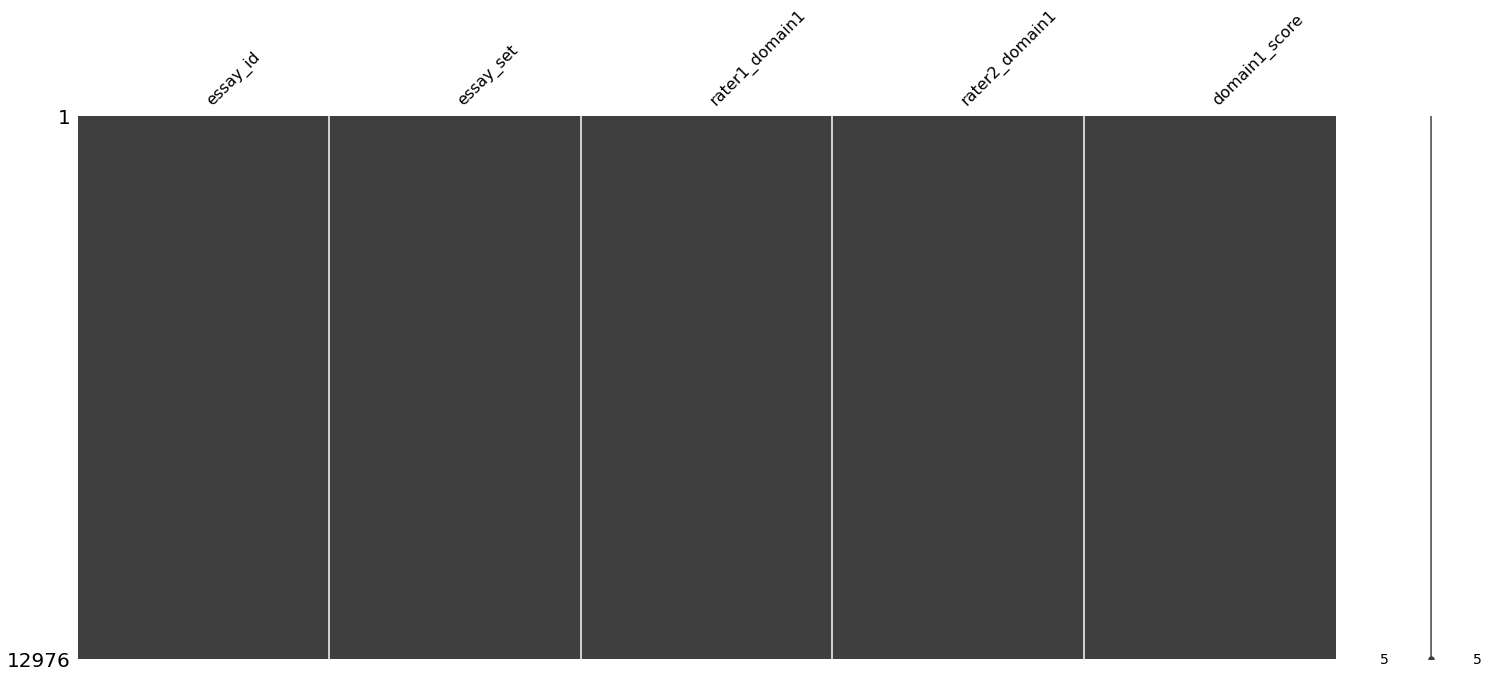

In [29]:
fig = msno.matrix(df.sample(12976))
grid_ax = fig.axes

In [30]:
df.isna().sum()

essay_id          0
essay_set         0
rater1_domain1    0
rater2_domain1    0
domain1_score     0
dtype: int64

In [12]:
df.mean()

essay_id          10295.395808
essay_set             4.179485
rater1_domain1        4.127158
rater2_domain1        4.137408
domain1_score         6.800247
dtype: float64

In [15]:
df.groupby('essay_set').domain1_score.mean()

essay_set
1     8.528323
2     3.415556
3     1.848204
4     1.432203
5     2.408864
6     2.720000
7    16.062460
8    36.950207
Name: domain1_score, dtype: float64

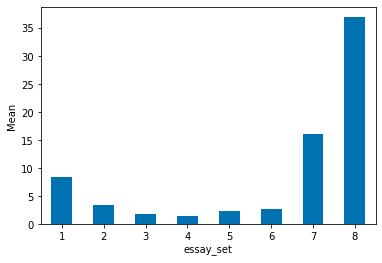

In [19]:
df.groupby('essay_set').domain1_score.mean().plot.bar(y='essay', rot=0, legend=False)
plt.ylabel('Mean')
plt.show()

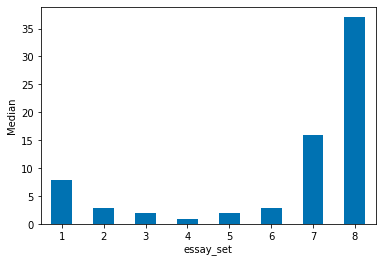

In [20]:
df.groupby('essay_set').domain1_score.median().plot.bar(y='essay', rot=0, legend=False)
plt.ylabel('Median')
plt.show()

In [7]:
train.sample(3)

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
1092,1095,1,"Dear Newspaper, I thought that I should express my concern. @CAPS4 are becoming to dependant on ...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7240,11988,5,"In the memoir the author has various moods. In paragraph @NUM1 it @CAPS1, ""In 1961, I was born i...",3,2,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3050,4245,2,I believe that if it has offensive language then it shouldn't be left of the shelf. Also it real...,2,2,NaN,2,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12976 non-null  int64  
 1   essay_set       12976 non-null  int64  
 2   essay           12976 non-null  object 
 3   rater1_domain1  12976 non-null  int64  
 4   rater2_domain1  12976 non-null  int64  
 5   rater3_domain1  128 non-null    float64
 6   domain1_score   12976 non-null  int64  
 7   rater1_domain2  1800 non-null   float64
 8   rater2_domain2  1800 non-null   float64
 9   domain2_score   1800 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

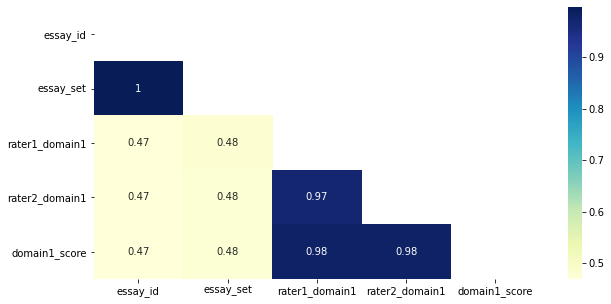

In [35]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
_=sns.heatmap(corr, cmap='YlGnBu', annot=True, mask=mask)

In [8]:
data = train[['essay_set','essay','domain1_score']].copy()

### Number of essays in each set

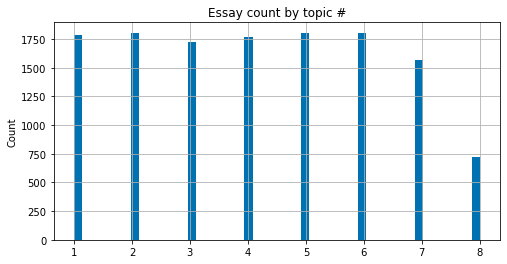

In [56]:
df.loc[:,['essay_set']].hist(bins=50, figsize=(8, 4))
plt.title('Essay count by topic #')
plt.ylabel('Count')
plt.show()

### Essay word count by topic

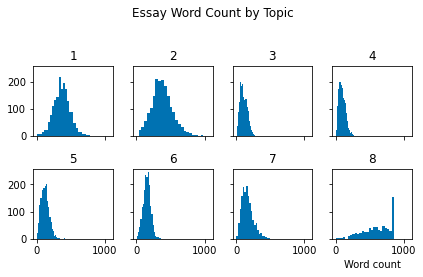

In [57]:
train['word_count'] = train['essay'].str.strip().str.split().str.len()

train.hist(column='word_count', by='essay_set', bins=25, sharey=True, sharex=True, layout=(2, 4), rot=0)

plt.suptitle('Essay Word Count by Topic')
plt.xlabel('Word count')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [59]:
train.groupby(['essay_set']).agg(['min','max','count','nunique'])

essay_id                                                                                                                     essay                                                                                                                    rater1_domain1                   rater2_domain1                   rater3_domain1                     domain1_score                   rater1_domain2                    rater2_domain2                    domain2_score                     \
               min    max count nunique                                                                                                  min                                                                                                  max count nunique            min max count nunique            min max count nunique            min   max count nunique           min max count nunique            min  max count nunique            min  max count nunique           min  max count nunique   
essay_set                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
1                1   1787  1783    1783  @CAPS1 dinners ready okay mom, one second' click, click, click. Are you hearing this from your c...  would you rather read six books to get that one recipie, or would you rather look it up in less ...  1783    1783              1   6  1783       6              1   6  1783       6            NaN   NaN     0       0             2  12  1783      11            NaN  NaN     0       0            NaN  NaN     0       0           NaN  NaN     0       0   
2             2978   4777  1800    1800  ' Everyone in the world has an opinion, some people @MONTH1 find them offensive but there are al...  yes i thinck they should take efence books off the shelf because little likd read the books then...  1800    1800              1   6  1800       6              1   6  1800       6            NaN   NaN     0       0             1   6  1800       6            1.0  4.0  1800       4            1.0  4.0  1800       4           1.0  4.0  1800       4   
3             5978   7708  1726    1726    The setting causes major problems for the cyclist in the essay, Do Not Exceed Posted Speed Li...  Do not Exceed the posted speed limit tells a story of learning and determination, as one cycli...  1726    1724              0   3  1726       4              0   3  1726       4            NaN   NaN     0       0             0   3  1726       4            NaN  NaN     0       0            NaN  NaN     0       0           NaN  NaN     0       0   
4             8863  10642  1770    1770    In the article the author concludes the story with Saeng vowing to herself that in the spring...  when they come back, Saeng vowed silently to herself, in the spring, when the snow melt and the...  1770    1768              0   3  1770       4              0   3  1770       4            NaN   NaN     0       0             0   3  1770       4            NaN  NaN     0       0            NaN  NaN     0       0           NaN  NaN     0       0   
5            11827  13631  1805    1805       In the memoir, Narciso Rodriguez, he included many stories about his "family" and parents. ...  within its walls, my young parents in the immigrant sectional of newark, new jersey. within its ...  1805    1805              0   4  1805       5              0   4  1805       5            NaN   NaN     0       0             0   4  1805       5            NaN  NaN     0       0            NaN  NaN     0       0           NaN  NaN     0       0   
6            14834  16633  1800    1800   There were many obstacle

In [60]:
df.groupby(['essay_set'])['domain1_score'].agg(['min','max','count','nunique'])

,min,max,count,nunique
essay_set,,,,
1,2,12,1783,11
2,1,6,1800,6
3,0,3,1726,4
4,0,3,1770,4
5,0,4,1805,5
6,0,4,1800,5
7,2,24,1569,23
8,10,60,723,34


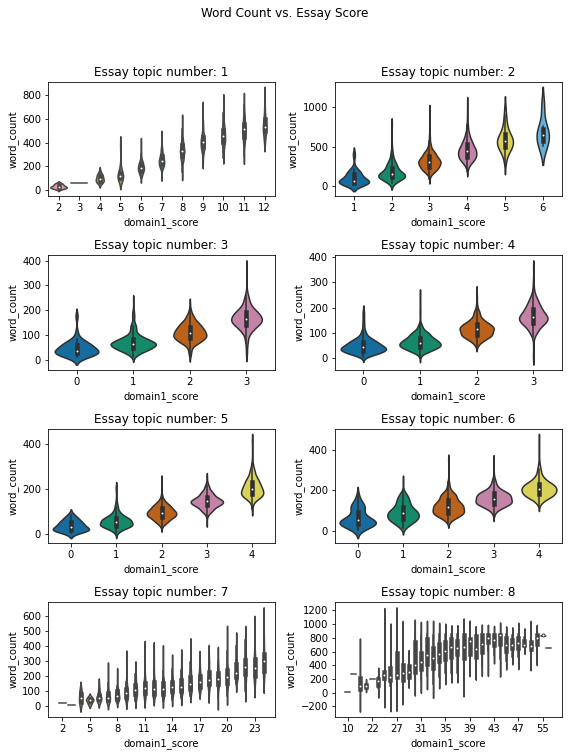

In [68]:
topic_num = 0
fig, ax = plt.subplots(4,2, figsize=(8, 11))

for i in range(4):
    for j in range(2):
        topic_num += 1
        sns.violinplot(x='domain1_score', y='word_count', data=train[train['essay_set'] == topic_num], ax=ax[i,j])
        ax[i,j].set_title('Essay topic number: %i' % topic_num)
        
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Word Count vs. Essay Score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

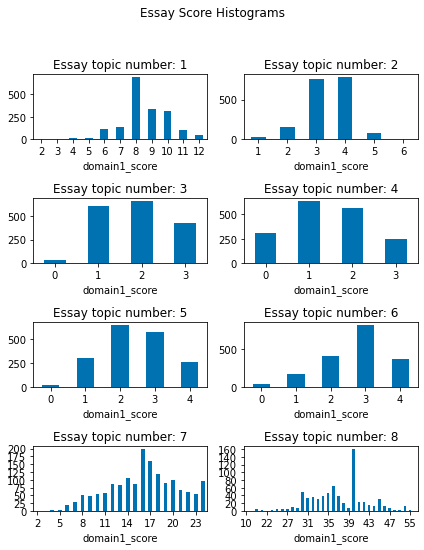

In [69]:
topic_num = 0
fig, ax = plt.subplots(4,2, figsize=(6,8), sharey=False)

for i in range(4):
    for j in range(2):
        topic_num += 1
        train[train['essay_set'] == topic_num].groupby('domain1_score')['essay_id'].agg('count').plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Essay topic number: %i' % topic_num)
        
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)

plt.suptitle('Essay Score Histograms')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()